CIRCLES
[(59, 142, 30), (80, 51, 34), (169, 98, 22)]
[173.88098148527007, 261.2711781403437] a
[259.94140501507167, 133.09760841060296] a
[-189.61435669109636, 87.16535803542021] a
[129.30589042651482, 372.3305884099551] a
[-19.397720715071408, 160.54058074338423] a
[-9.671106397009853, 133.54176006674345] a
CENTER [142, 59]
CENTER [98, 169]
CENTER [51, 80]
[<vertex.VertexDescendant object at 0x000001F6A2DD7248>, -0.0] aaaaaaaaaaaa
No vertex was added!
No vertex was added!
----------------------------------------------------------------------------------------------------
99
87
12
----------------------------------------------------------------------------------------------------


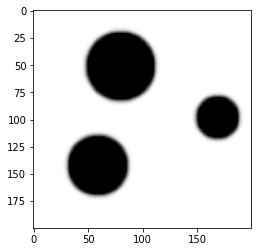

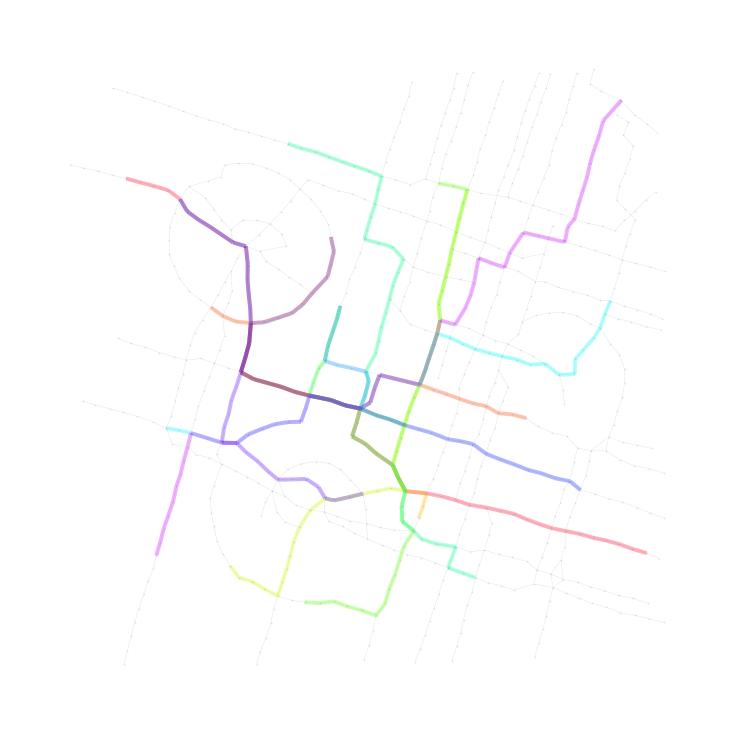

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import glob
import networkx as nx
import numpy as np
import os
import cv2
import math
import random
import bisect
import copy
from scipy.spatial import Voronoi, voronoi_plot_2d
from itertools import accumulate
from copy import deepcopy
from itertools import accumulate, combinations

from randomScatter import RandomScatter
from direction import Direction
from vertex import VertexBase, VertexOrigin, VertexLayer

def intersection(x1,x2,y1,y2,r1,r2):
    d = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    if d < r1 + r2 + 20:
        return True
    else:
        return False
def get_cmap(n, name='hsv'):
        return plt.cm.get_cmap(name, n)

depot_loc = 'out'

for trial in range(1):
    # TEST    
    trialstr=str(trial)
    city_names=['small','medium','big']
    num_centers= 3 #random.choice([1,2,3])
    city_size=[50,100,200]
    buffer_size=[5,10,20]
    # ------------------------------
    for index in range(1):
    #     num_radial_centres = random.randint(1,3)
        width = 200
        height = 200
        buffer = 20
        num_radial_centres = num_centers#[index]
        width = height = 200# city_size[index]
        buffer = buffer_size[index]
        city_name=city_names[index]

        circles = []
        
        if not os.path.exists(city_name+"/"+trialstr):
            os.mkdir(city_name+"/"+trialstr)

        for i in range(num_radial_centres):    
            for i in range(1000):
                radius = random.randint(20, 50)# random.randint(buffer//2, width//3) # TEST
                cen_x = random.randint(buffer+radius,width-buffer-radius)
                cen_y = random.randint(buffer+radius,height-buffer-radius)
                if not any(map(lambda circle: intersection(cen_x, circle[0],cen_y, circle[1],radius, circle[2]), circles)):
                    circles.append((cen_x, cen_y, radius))
                    break

#         print('CIRCLES')
#         print(circles)
        # img = np.ones((width,height))*255
        img = np.zeros((width,height))
        for circle in circles:
        #     cv2.circle(img, (circle[0],circle[1]),circle[2],(0),cv2.FILLED)
            cv2.circle(img, (circle[0],circle[1]),circle[2],(255),cv2.FILLED)
#         plt.imshow(img,cmap='Greys')
#         cv2.imwrite(city_name+"/"+trialstr+"/"+"/scatter_rate.jpg",img)

        num = 1
        for circle in circles:
            img2 = np.ones((width,height))*255
            cv2.circle(img2, (circle[0],circle[1]),circle[2],(0),cv2.FILLED)
            cv2.imwrite(city_name+"/"+trialstr+"/"+'circle'+str(num)+".jpg",img2)
            num += 1

        kernel = np.ones((7,7),np.float32)/(7**2)
        dst = cv2.filter2D(img,-1,kernel)**2/255

        plt.imshow(dst,cmap='Greys')
        cv2.imwrite(city_name+"/"+trialstr+"/"+"scatter_rate.jpg",dst)


        ERROR_MESSAGE = '----------------------'
        IMAGE_INPUT_PATH = city_name+"/"+trialstr+"/"+'scatter_rate.jpg'
        IMAGE_OUTPUT_PATH = city_name+"/"+trialstr+"/"+'image_output/'
        ROADMAP_RECTANGLE = ['./image_input/roadMapRectangle_00.jpg']
        ROADMAP_CIRCLE = [i for i in glob.glob(city_name+"/"+trialstr+"/"+"circle*.jpg")]

        random.shuffle(ROADMAP_CIRCLE)

    #     if not os.path.exists(IMAGE_OUTPUT_PATH):
    #         os.mkdir(IMAGE_OUTPUT_PATH)

        randomScatterInstance = RandomScatter(IMAGE_INPUT_PATH, 50, 0, reverse=True, squared=True)
        randomScatterInstance.readImage()
        randomScatterInstance.randomDots()
        randomScatterInstance.makePoints()

        #run improvePoints twice to refine points' locations
        randomScatterInstance.improvePoints(randomScatterInstance.points)
        _, graph, points = randomScatterInstance.improvePoints(randomScatterInstance.improvedPoints) * 1
#         print(points[0], 'b')
        directionInstance = Direction(ROADMAP_RECTANGLE, ROADMAP_CIRCLE)

        vertexLayertInstance = VertexLayer(randomScatterInstance, directionInstance)

#         plt.show()
#         fig = plt.figure(figsize=(10,10))
#         ax = plt.gca()
#         ax.set_xlim(left=0, right=randomScatterInstance.shape[1])
#         ax.set_ylim(top=height, bottom=0)#randomScatterInstance.shape[0])
#         plt.figure(1,figsize=(10,10)) 

        verts = []
        vertexlist={}
        vertexdem = {}
        c=0
        adjdict={}
        for i in range(20):
            vertexLayertInstance.getNextVertices()
            vertexLayertInstance.mergeNextVertices(5)
            vertexLayertInstance.mergeToAll(3)
            if len(vertexLayertInstance.verticesNext)<=3:
                vertexLayertInstance.changeNextVertices()
                break
#             vertexLayertInstance.plotLines(vertexLayertInstance.verticesNext, True)
            for i in vertexLayertInstance.verticesNext:
                if tuple(i.position) not in vertexlist:
                    vertexlist[tuple(i.position)] = i.index
                    verts.append(i.index)
                    vertexdem[tuple(i.position)] = i.dem
    #                 c+=1

            for i in vertexLayertInstance.verticesNext:
                for j in i.comesFrom:
                    if tuple(i.position) not in vertexlist:
                        vertexlist[tuple(i.position)] = i.index
                        verts.append(i.index)
                        vertexdem[tuple(i.position)] = i.dem
    #                     c+=1

                    if tuple(j[0].position) in vertexlist:
                        if vertexlist[tuple(j[0].position)] in adjdict:
                            adjdict[vertexlist[tuple(j[0].position)]].update({vertexlist[tuple(i.position)]:{'weight':j[0].getDistance(i)}})
                        else:
                            adjdict[vertexlist[tuple(j[0].position)]] = {vertexlist[tuple(i.position)]:{'weight':j[0].getDistance(i)}}
                    else:
                        vertexlist[tuple(j[0].position)] = j[0].index
                        verts.append(j[0].index)
                        vertexdem[tuple(j[0].position)] = j[0].dem
    #                     c+=1
                        if vertexlist[tuple(j[0].position)] in adjdict:
                            adjdict[vertexlist[tuple(j[0].position)]].update({vertexlist[tuple(i.position)]:{'weight':j[0].getDistance(i)}})
                        else:
                            adjdict[vertexlist[tuple(j[0].position)]] = {vertexlist[tuple(i.position)]:{'weight':j[0].getDistance(i)}}

                for j in i.goesTo:
                    if tuple(j[0].position) not in vertexlist:
                        vertexlist[tuple(j[0].position)] = j[0].index
                        verts.append(j[0].index)
                        vertexdem[tuple(j[0].position)] = j[0].dem
    #                     c+=1

                    if tuple(i.position) in vertexlist:
                        if vertexlist[tuple(i.position)] in adjdict:
                            adjdict[vertexlist[tuple(i.position)]].update({vertexlist[tuple(j[0].position)]:{'weight':i.getDistance(j[0])}})
                        else:
                            adjdict[vertexlist[tuple(i.position)]] = {vertexlist[tuple(j[0].position)]:{'weight':i.getDistance(j[0])}}
                    else:
                        vertexlist[tuple(i.position)] = i.index
                        verts.append(i.index)
                        vertexdem[tuple(i.position)] = i.dem
    #                     c+=1
                        if vertexlist[tuple(i.position)] in adjdict:
                            adjdict[vertexlist[tuple(i.position)]].update({vertexlist[tuple(j[0].position)]:{'weight':i.getDistance(j[0])}})
                        else:
                            adjdict[vertexlist[tuple(i.position)]] = {vertexlist[tuple(j[0].position)]:{'weight':i.getDistance(j[0])}}

            vertexLayertInstance.changeNextVertices()

        for i in vertexLayertInstance.verticesAll:
            if tuple(i.position) not in vertexlist:
                vertexlist[tuple(i.position)]=i.index
    #             c+=1

        vertexlistinv = {v: k for k, v in vertexlist.items()}
#         vertexLayertInstance.plotVertices(vertexLayertInstance.verticesOrigin, alpha = 1.0)

        x_coor = []
        y_coor = []
        for ver in points:
            x_coor.append(ver[0])
            y_coor.append(ver[1])
#         plt.scatter(x_coor, y_coor, c='#00ff00', alpha = 1.0)

        vertexpos={}
        for k,v in vertexlistinv.items():
            pos=v
            vertexpos[k] = pos[::-1]

        G = nx.Graph(adjdict)
        G.remove_edges_from(nx.selfloop_edges(G))
        unneeded = []
        for n in G.nodes:
            if len(list(G.neighbors(n))) == 1:
                nbrs = list(G.neighbors(n))
                if len(list(G.neighbors(nbrs[0]))) > 2:
                    unneeded.append(n)
        # print(unneeded)
        for i in range(len(unneeded)):
            G.remove_node(unneeded[i])
#         plt.figure(1,figsize=(10,10)) 
#         nx.draw(G, vertexpos, node_size=10, font_size=8)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_init.jpg')
#         plt.show()

        T = deepcopy(G)

        combs = list(combinations(G.nodes(), 2))
        nodes_to_remove = []
        edges_to_add = []
        for n1,n2 in combs:
        #     print(vertexpos[n1], vertexpos[n2])
            if n1 in T.nodes() and n2 in T.nodes():
                temp = math.sqrt((vertexpos[n1][0] - vertexpos[n2][0]) ** 2.0 + (vertexpos[n1][1] - vertexpos[n2][1]) ** 2.0)
                if temp < 3:# and n1 not in T.neighbors(n2):
                    for n in T.neighbors(n1):
                        edges_to_add.append((n2, n))
                    if n1 not in nodes_to_remove:
                        nodes_to_remove.append(n1)

        T.add_edges_from(edges_to_add) 
        for node in nodes_to_remove:
            T.remove_node(node)
        T.remove_edges_from(nx.selfloop_edges(T))
        # print(len(T.edges()))
#         fig = plt.figure(figsize=(10,10))
#         nx.draw(T, vertexpos, node_size=10, font_size=8)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_wo_node.jpg')
#         plt.show()

        nw_points = []
        for ver in T.nodes():
            if len(list(T.neighbors(ver))) >= 4:
                nw_points.append(ver)

        nw_pts = deepcopy(nw_points)

#         plt.figure(1,figsize=(10,10)) 
        x_co = []
        y_co = []
        for ver in nw_points:
            x_co.append(vertexpos[ver][0])
            y_co.append(vertexpos[ver][1])

#         plt.scatter(x_co, y_co, c='#0000ff', alpha = 1.0)
#         nx.draw(T, vertexpos, node_size=10, font_size=8)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_w_node.jpg')
#         plt.show()

        temps = []
        for pt in points:
            nearest = 50000
            best_pt = None
            for nd in T.nodes():
                ver = vertexpos[nd]
                temp = math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(ver, pt)))

                key_v=vertexlist[ver[::-1]]
                if key_v in adjdict:
                    deg=len(adjdict[key_v])
                else:
                    deg=0.001
                vvv = (1/vertexdem[ver[::-1]])*(1/deg)*temp
                if vvv < nearest:
                    best_pt = ver
                    nearest = vvv

            temps.append(best_pt)

        for el in nw_points:
            temps.append(vertexpos[el])

#         print(len(temps))
        new_points = []
        for el in temps:
            if el not in new_points:
                new_points.append(el)
#         print(len(new_points))
        plt.figure(1,figsize=(10,10)) 
        x_co = []
        y_co = []
        for ver in new_points:
            x_co.append(ver[0])
            y_co.append(ver[1])

#         plt.scatter(x_co, y_co, c='#0000ff', alpha = 1.0)

#         nx.draw(T, vertexpos, node_size=10, font_size=8)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_w_node2.jpg')

        vertexposinv={v:k for (k,v) in vertexpos.items()}
        labels = []
        for pt in new_points:
        #     print(pt)
            labels.append(vertexposinv[pt])

#         fig, ax = plt.subplots(figsize=(10,10))
#         ax.scatter(x_co, y_co, c='#00ff00', alpha = 1.0)
#         for i, txt in enumerate(labels):
#             ax.annotate(txt, (x_co[i], y_co[i]))
#         nx.draw(T, vertexpos, node_size=10, font_size=10)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_w_node_labels.jpg')
        '''
        CITY STRUCTURE CREATED HERE
        
        Things to pass:
        new_points
        vertexpos, vertexposinv, T, circles
        '''
        
        if depot_loc == 'in':
            max_num = 0
            max_cen = None

            for circle in circles:
                pt_num = 0
                for pt in new_points:
                    if math.sqrt((pt[0] - circle[0]) ** 2.0 + (pt[1] - circle[1]) ** 2.0) <= 30:
                        pt_num += 1
                if pt_num > max_num:
                    max_cen = (circle[0], circle[1])
                    max_num = pt_num
            #             best_cand = pt

#             print(max_cen)

            best_cand_dist = 200
            best_cand = None

            for pt in new_points:
                dist = math.sqrt((pt[0] - max_cen[0]) ** 2.0 + (pt[1] - max_cen[1]) ** 2.0)
                if dist <= best_cand_dist:
                    best_cand = pt
                    best_cand_dist = dist

#             print(best_cand)
#             print(best_cand_dist)
            best_cand_id = vertexposinv[best_cand]
#             print(best_cand_id)

            dep_x_co, dep_y_co = max_cen#best_cand
            temp_x_co = [dep_x_co, best_cand[0]]
            temp_y_co = [dep_y_co, best_cand[1]]

#             fig, ax = plt.subplots(figsize=(20,20))
#             plt.scatter(temp_x_co, temp_y_co, c='#ff0000', alpha = 1.0)

#             nx.draw(T, vertexpos, node_size=15, font_size=10)
        else:
            min_num = 1000
            min_cen = None

            for circle in circles:
                pt_num = 0
                for pt in new_points:
                    if math.sqrt((pt[0] - circle[0]) ** 2.0 + (pt[1] - circle[1]) ** 2.0) <= 30:
                        pt_num += 1
            #     print(pt_num, circle)
                if pt_num < min_num:
                    min_cen = (circle[0], circle[1])
                    min_num = pt_num

#             print(min_cen, min_num)

            best_cand_dist = 2000000
            best_cand = None

            for pt in new_points:
                dist = math.sqrt((pt[0] - min_cen[0]) ** 2.0 + (pt[1] - min_cen[1]) ** 2.0)
                if dist <= best_cand_dist:
                    best_cand = pt
                    best_cand_dist = dist

#             print(best_cand)
#             print(best_cand_dist)
            best_cand_id = vertexposinv[best_cand]
#             print(best_cand_id)

            dep_x_co, dep_y_co = min_cen
            temp_x_co = [dep_x_co, best_cand[0]]
            temp_y_co = [dep_y_co, best_cand[1]]

#             fig, ax = plt.subplots(figsize=(20,20))
#             plt.scatter(temp_x_co, temp_y_co, c='#ff0000', alpha = 1.0)
#             nx.draw(T, vertexpos, node_size=15, font_size=10)

            new_points_copy = deepcopy(new_points)
            new_points.remove(best_cand)


        visited = []
        path_list = []

        paths = []

        for n1, n2 in combinations(new_points, 2):
            paths.append(nx.shortest_path(T, vertexposinv[n1], vertexposinv[n2]))

        '''
        for pts in new_points, split into pairs (preferably diametrically opposite)
        try to grow shortest path between pairs, including 
        '''
        path_list = []

        for pt in new_points:
            direction = (200-pt[0], 200-pt[1])
            nearest = 5000
            best_pt = None
            for ver in new_points:
                temp = math.sqrt((direction[0] - ver[0]) ** 2.0 + (direction[1] - ver[1]) ** 2.0)
                if temp < nearest:
                    best_pt = ver
                    nearest = temp
            path_list.append(nx.shortest_path(T,vertexposinv[pt],vertexposinv[best_pt]))
        
        print('-'*100)
        print(len(path_list))

        removed = []
        for i in range(len(path_list)):
            for j in range(i+1,len(path_list)):
                temp_1 = None
                temp_2 = None
                if len(path_list[i]) >= len(path_list[j]):
                    temp_1 = path_list[i]
                    temp_2 = path_list[j]
                else:
                    temp_1 = path_list[j]
                    temp_2 = path_list[i]
                if len(set(temp_1).intersection(set(temp_2))) >= 0.65*len(temp_2):
                    if temp_2 not in removed:
                        removed.append(temp_2)

        print(len(removed))

        for i in removed:
            path_list.remove(i)

        print(len(path_list))
        print('-'*100)

        '''
        look at all remaining stops
        pick end node of path, iteratively connect to nearest stop until cannot find more

        '''
        covered = []
        for path in path_list:
            for el in path:
        #         print(vertexpos[el])
        #         print(el)
                if el not in covered and vertexpos[el] in new_points:
                    covered.append(el)
        remaining = [vertexposinv[el] for el in new_points]
        # print(remaining)
        for pt in covered:
            remaining.remove(pt)
        # temp = 0
#         print(remaining)


        longest = []
        for n1, n2 in combinations(remaining,2):
            pth = nx.shortest_path(T, n1, n2)
            if any(i in covered for i in pth) == False:
                if len(pth) >= len(longest):
                    longest = pth

#         print(len(longest), longest)

#         fig, ax = plt.subplots(figsize=(10,10))
#         ax.scatter(x_co, y_co, c='#00ff00', alpha = 1.0)
#         for i, txt in enumerate(labels):
#             ax.annotate(txt, (x_co[i], y_co[i]))
#         nx.draw(T, vertexpos, node_size=15, font_size=10)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_w_node_labels2.jpg')

        rem_x_co = []
        rem_y_co = []
        for ver in remaining:
            rem_x_co.append(vertexpos[ver][0])
            rem_y_co.append(vertexpos[ver][1])

#         plt.figure(figsize=(10,10))
#         plt.scatter(x_co, y_co, c='#00ff00', alpha = 1.0)
#         plt.scatter(rem_x_co, rem_y_co, c='#ff0000', alpha = 1.0)
#         nx.draw(T, vertexpos, node_size=10, font_size=8,width=0.5)
# #         plt.savefig(city_name+"/"+trialstr+"/"+'graph_imp_nodes.jpg')


        P = nx.Graph()
        edges = []
        for path in path_list:
            path_edges = [(path[n], path[n+1]) for n in range(len(path)-1)]
            P.add_nodes_from(path)
            P.add_edges_from(path_edges)
            edges.append(path_edges)

        pos = nx.spring_layout(P)
        colors = get_cmap(len(path_list))

        linewidths = [2*i for i in range(len(path_list))]

        cm = plt.get_cmap('gist_rainbow')
        NUM_COLORS=len(edges)
        
        if not os.path.exists(city_name+"/"+trialstr+"/graph_edges/"):
            os.mkdir(city_name+"/"+trialstr+"/graph_edges/")
        
#         for ctr, edgelist in enumerate(edges):
#             plt.figure(figsize=(5,5))
#             nx.draw(T, vertexpos, node_size=1, font_size=8, width=0.5)

#             plt.scatter(x_co, y_co, c='#000000', alpha = 0.2)
#             plt.scatter(rem_x_co, rem_y_co, c='#ff0000', alpha = 0.2)
#             nx.draw_networkx_edges(P, pos=vertexpos, edgelist=edgelist, edge_color = cm(ctr/NUM_COLORS), width = 4 ,node_size= 1)
#             plt.savefig(city_name+"/"+trialstr+"/graph_edges/"+str(ctr)+'.jpg')
#             plt.show()
    # plt.show()
    # plt.savefig('this.png')
        pos = nx.spring_layout(P)
        colors = get_cmap(len(path_list))
        linewidths = [2*i for i in range(len(path_list))]

        plt.figure(figsize=(10,10))

        nx.draw(T, vertexpos, node_size=1, font_size=8, alpha=0.1, width=0.5)

        cm = plt.get_cmap('gist_rainbow')
        NUM_COLORS=len(edges)
        for ctr, edgelist in enumerate(edges):
            plt.scatter(x_co, y_co, c='#000000', alpha = 0.0)
            plt.scatter(rem_x_co, rem_y_co, c='#FFA500', alpha = 0.0)
            nx.draw_networkx_edges(P, pos=vertexpos, edgelist=edgelist, edge_color = cm(ctr/NUM_COLORS), alpha = 0.3, width = 4 ,node_size= 10)

        plt.savefig(city_name+"/"+trialstr+"/"+'paths.png')
        plt.show()

        '''
        path extension
        find closest node to extend path
        ensure that there are no loops
        repeat until path cannot be extended (either everything in visited or no existing path)
        '''

#         new_paths = deepcopy(path_list)
#         updated_paths = []
#         cov = []

#         # make visited

#         # vis = []

#         for path in new_paths:
#             Q=deepcopy(T)
#             possible = []
#             Q.remove_edge(path[-1], path[-2])
#             new = deepcopy(path)
#             for pt in remaining:
#                 closest = pt
#                 if nx.has_path(Q, path[-1], pt):# and pt not in vis:
#                     temp = nx.shortest_path(Q, path[-1], pt)
#                     temp.pop(0)
#                     if any(i in temp for i in path) == False:
#                         possible.append(temp)
#                         cov.append(pt)
#         #                 vis.append(pt)
#             if possible != []:
#                 possible.sort(key = len)
#                 extenx = possible[0]
#         #         print(len(extenx), 'a')
#                 new.extend(extenx)
#         #         updated_paths.append(path)
#             possible = []

#             Q.remove_edge(path[0], path[1])
#             for pt in remaining:
#                 closest = pt
#                 if nx.has_path(Q, path[0], pt):# and pt not in vis:
#                     temp = nx.shortest_path(Q, pt, path[0])
#                     temp.pop(-1)
#                     if any(i in temp for i in path) == False:
#                         possible.append(temp)
#                         cov.append(pt)
#         #                 vis.append(pt)
#             if possible != []:
#                 possible.sort(key = len)
#                 extenx = possible[0]
#         #         print(len(extenx), 'b')
#                 new = extenx + new
#         #         updated_paths.append(extenx)
#         #     else:
#         #         print('aaaaaaaaaaaaaaaaaaaa')
#             if len(path) != len(new):
#                 updated_paths.append(new)


#         updated = new_paths[0]

#         Y = nx.Graph()
#         ejs = []
#         for path in updated_paths:
#             ej = [(path[n], path[n+1]) for n in range(len(path)-1)]
#             Y.add_nodes_from(path)
#             Y.add_edges_from(ej)
#             ejs.append(ej)

#         cm = plt.get_cmap('gist_rainbow')
#         NUM_COLORS=len(ejs)

#         plt.figure(figsize=(10,10))
#         plt.scatter(x_co, y_co, c='#0000ff', alpha = 0.1)
#         nx.draw(T, vertexpos, node_size=10, font_size=8,width=0.5)
#         nx.draw(T, vertexpos, node_size=1, font_size=8, alpha=0.1, width=0.5)

#         for ctr, edgelist in enumerate(ejs):
#             nx.draw_networkx_edges(Y, pos=vertexpos, edgelist=edgelist, edge_color = cm(ctr/NUM_COLORS), alpha = 0.3, width = 4 ,node_size= 10)
#         plt.savefig(city_name+"/"+trialstr+"/"+'paths_extended.png')
#         plt.show()

        line_pool = {}
        period = 10
        pool = []
        dist_id = []
        for path in path_list:
            stops = []
            dists = []
            for p in range(len(path)):
                if vertexpos[path[p]] in new_points:
                    stops.append(path[p])
                    dists.append(p)
            dist_id.append(dists)
            pool.append(stops)

#         print(pool[0])
        start = 6.0
        for i in range(len(pool)):
            times = [start + t/50 for t in dist_id[i]]
            line_pool.update({tuple(pool[i]):(start, times)})


        '''
        Feasible paths
        '''

#         L = nx.Graph()
#         edjs = []

#         for line in line_pool.keys():
#         #     print(list(line))
#             temp = list(line)
#             edj = [(temp[n], temp[n+1]) for n in range(len(temp)-1)]
#         #     print(edj)
#             L.add_nodes_from(path)
#             L.add_edges_from(ej)
#             edjs.append(edj)

#         cm = plt.get_cmap('gist_rainbow')
#         NUM_COLORS=len(edjs)

#         cov_x = []
#         cov_y = []
#         for ver in covered:
#             cov_x.append(vertexpos[ver][0])
#             cov_y.append(vertexpos[ver][1])

#         plt.figure(figsize=(10,10))
#         plt.scatter(cov_x, cov_y, c='#000000', alpha = 0.2)

#         for ctr, edgelist in enumerate(edjs):
#             nx.draw_networkx_edges(L, pos=vertexpos, edgelist=edgelist, edge_color = cm(ctr/NUM_COLORS), alpha = 0.5, width = 4 ,node_size= 10)
#         plt.savefig(city_name+"/"+trialstr+"/"+'paths_extended2.png')
#         plt.show()

#         if not os.path.exists(city_name+"/"+trialstr+"/paths/"):
#             os.mkdir(city_name+"/"+trialstr+"/paths/")
        
#         for ctr, edgelist in enumerate(edjs):
#             plt.figure(figsize=(10,10))
#             plt.scatter(cov_x, cov_y, c='#000000', alpha = 0.2)
#         #     nx.draw(T, vertexpos, node_size=0, font_size=10)
#             nx.draw_networkx_edges(L, pos=vertexpos, edgelist=edgelist, edge_color = cm(ctr/NUM_COLORS), alpha = 0.5, width = 4 ,node_size= 10)
#             plt.savefig(city_name+"/"+trialstr+"/paths/"+str(ctr)+'.png')
#             plt.show()

            
#         with open(city_name+"/"+trialstr+"/"+'graph.pkl','w') as f:
#             pickle.dump(f,G)
#         with open(city_name+"/"+trialstr+"/"+'test_lc.txt', 'w') as f:
#             f.write('# line-id; edge-order; edge-id; frequency')
#         #     f.write('\n')
#             for i in range(len(edges)):
#         #         p = path[i]
#                 for j in range(len(edges[i])):
#         #             print(edge_id[edges[i][j]])
#                     f.write('\n')
#                     f.write(str(i)+ ';' + str(j) + ';' + str(edge_id[edges[i][j]]) + ';' + '0')

In [11]:
for path in updated_paths:
    print(path[0], path[-1])

2807 2815
3232 2591
3232 2933
3117 2735
2735 3082
2815 2616
2815 3052
3351 2775
2597 2933
2735 2807
2735 3052


(37, 44)
(58.968083802537635, 34.70298894048044)
23.854373196463275
286


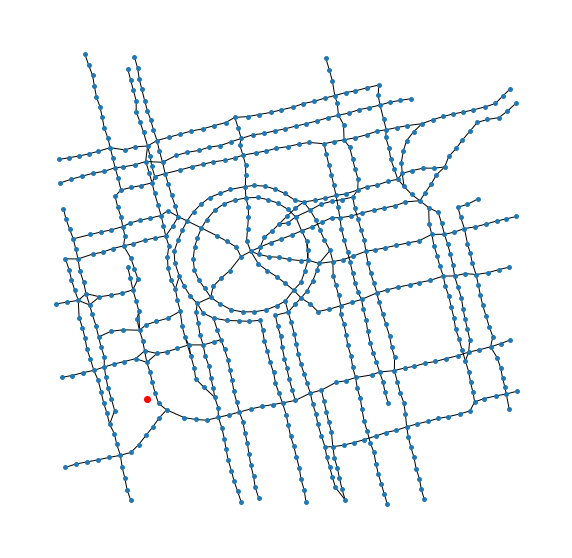

In [4]:
max_num = 0
max_cen = None
# for circle in circles:
# #     print(circle)
#     if circle[2] > max_rad:
#         max_rad = circle[2]
#         max_cen = (circle[0], circle[1])

for circle in circles:
    for pt in new_points:
        pt_num = 0
        if math.sqrt((pt[0] - circle[1]) ** 2.0 + (pt[1] - circle[0]) ** 2.0) <= circle[2]:
            pt_num += 1
        if pt_num > max_num:
            max_cen = (circle[1], circle[0])
            
print(max_cen)
# print(remaining)
depot_cand = [vertexpos[el] for el in remaining]

best_cand_dist = 200
best_cand = None

for pt in depot_cand:
#     print(pt)
#     break
    dist = math.sqrt((pt[0] - max_cen[0]) ** 2.0 + (pt[1] - max_cen[1]) ** 2.0)
    if dist <= best_cand_dist:
        if dist < best_cand_dist:
            best_cand = pt
            best_cand_dist = dist    

# for dep in depot_cand:
#     dist = math.sqrt((dep[0] - max_cen[0]) ** 2.0 + (dep[1] - max_cen[1]) ** 2.0)
#     if dist <= 10:
#         if dist < best_cand_dist:
#             best_cand = dep
#             best_cand_dist = dist

print(best_cand)
print(best_cand_dist)
best_cand_id = vertexposinv[best_cand]
print(best_cand_id)

x_co, y_co = max_cen

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(x_co, y_co, c='#ff0000', alpha = 1.0)

# ax.scatter(x_co, y_co, c='#00ff00', alpha = 1.0)
# for i, txt in enumerate(labels):
# ax.annotate(txt, (x_co, y_co))
nx.draw(T, vertexpos, node_size=15, font_size=10)

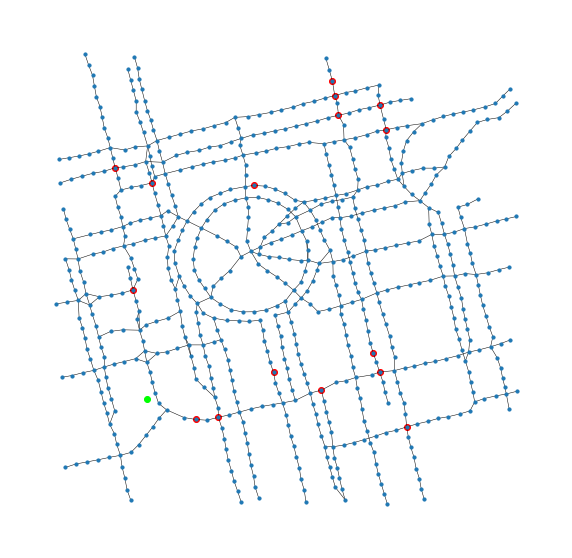

In [5]:
rem_x_co = []
rem_y_co = []
for ver in remaining:
    rem_x_co.append(vertexpos[ver][0])
    rem_y_co.append(vertexpos[ver][1])

plt.figure(figsize=(10,10))
plt.scatter(x_co, y_co, c='#00ff00', alpha = 1.0)
plt.scatter(rem_x_co, rem_y_co, c='#ff0000', alpha = 1.0)
nx.draw(T, vertexpos, node_size=10, font_size=8,width=0.5)

# print(rem_x_co)
# print(rem_y_co)

In [13]:
with open('line_concepts/test_lc.txt','r') as f:
    lines= [i.strip().split(";") for i in f.readlines()[1:]]
#     array = pickle.load('graphs.pkl')
print(lines)

[['0', '0', '1', '0'], ['0', '1', '2', '0'], ['1', '0', '3', '0'], ['1', '1', '4', '0'], ['1', '2', '5', '0'], ['1', '3', '6', '0'], ['2', '0', '4', '0'], ['2', '1', '7', '0'], ['2', '2', '8', '0'], ['3', '0', '7', '0'], ['3', '1', '8', '0'], ['3', '2', '9', '0'], ['3', '3', '10', '0'], ['4', '0', '11', '0'], ['4', '1', '9', '0'], ['4', '2', '10', '0']]


In [15]:
for i in lines:
    x= [int(j) for j in i]
    print(x)

[0, 0, 1, 0]
[0, 1, 2, 0]
[1, 0, 3, 0]
[1, 1, 4, 0]
[1, 2, 5, 0]
[1, 3, 6, 0]
[2, 0, 4, 0]
[2, 1, 7, 0]
[2, 2, 8, 0]
[3, 0, 7, 0]
[3, 1, 8, 0]
[3, 2, 9, 0]
[3, 3, 10, 0]
[4, 0, 11, 0]
[4, 1, 9, 0]
[4, 2, 10, 0]


In [9]:
lines[1]

'0;0;1;0\n'